# Support Vector Machine, SVM

### Постановка задачи
Осуществить визуализацию двух любых признаков и посчитать коэффициент корреляции между ними; выполнить разбиение классов набора данных с помощью LDA (LinearDiscriminantAnalysis), осуществить визуализацию разбиения; осуществить классификацию с помощью методов LDA и QDA (LinearDiscriminantAnalysis и QuadraticDiscriminantAnalysis); сравнить полученные результаты.
### Исходные данные
Датасет: https://archive.ics.uci.edu/ml/datasets/Website+Phishing<br>
Предметная область: Фишинговые сайты<br>
Задача: определить, фишинговый, подозрительный или нормальный сайт<br>
Количество записей: 1353<br>
Количество атрибутов: 9<br>
Атрибуты:
1. SFH {1,-1,0}
2. Pop-up Window  {1,-1,0}
3. SSL final state  {1,-1,0}
4. Request URL  {1,-1,0}
5. URL of Anchor  {1,-1,0}
6. Web traffic  {1,-1,0}
7. URL Length  {1,-1,0}
8. Age of domain  {1,-1}
9. Having IP Address {1,-1}

Во всех характеристиках значение «-1» означает «фишинговый», «0» - подозрительный, «1» - нормальный.<br>
### Описание параметров
__SFH (Server from handler)__ — Представление пользовательской информации, которая передается из веб страницы на сервер. Если оно пустое — сайт фишинговый, если передача идет на другой домен — подозрительный.
__Pop-up Window__ — Наличие всплывающего окна. Если при окне не доступен правый клик, то сайт фишинговый.<br>
__SSL final state__ — Подлинность SSL сертификата.<br>
__Request URL__ — Количество запросов к веб странице. Если их много, то, вероятно, сайт подвергся атаке, которая заменяет содержимое (текст/картинки). Если количество запросов велико — сайт фишинговый.<br>
__URL of Anchor__ — привязка к URL. Если при вводе адреса сайта в браузере происходит редирект на другой домен, то привязки нет. И если процент редиректов большой — сайт фишинговый.<br>
__Web traffic__ — объем веб трафиика сайта. У нормальных сайтов объем высокий, у фишинговых — низкий.<br>
__URL Length__ — Длина адреса сайта. Чем больше длина, тем выше вероятность, что в адрес встроен вредоносный код.<br>
__Age of domain__ — Возраст сайта. Если сайт существует менее полугода, то его можно заподозрить как фишинговый.<br>
__Having IP Address__ — Наличие IP адреса. Если адреса нет — сайт фишинговый.<br>

### Загрузка датасета

In [4]:
# coding=utf-8
from __future__ import division

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.svm import SVC


def load_data(filename):
    return pd.read_csv(filename, header=None).values


# разделение датасета на тестовую и обучающую выборку
def process_dataset(name):
    dataset = load_data(name)
    site_attr = dataset[:, :-1]  # список атрибутов для каждого сайта
    site_class = dataset[:, -1]  # класс (результат) сайта (норм, подозрительный, фишинговый)
    site_class = site_class.astype(np.float64, copy=False)
    site_attr = site_attr.astype(np.float64, copy=False)

    return site_attr, site_class


def train_split_dataset(site_attr, site_class, test_size, rnd_state):
    data_train, data_test, class_train, class_test = \
        train_test_split(site_attr, site_class, test_size=test_size, random_state=rnd_state)

    print_dataset_info(class_train, data_train)
    print_dataset_info(class_test, data_test)

    return data_train, data_test, class_train, class_test


def init(name):
    site_attr, site_class = process_dataset(name)
    print_dataset_info(site_class, site_attr)

    return site_attr, site_class

### Вывод информации о датасете

In [3]:
def print_dataset_info(site_class, site_attr):
    print('Number of records:', site_class.shape[0])
    print('Number of characters:', site_attr.shape[1])

    print('Class 0 (Normal): {:.2%}'.format(list(site_class).count(-1) / site_class.shape[0]))
    print('Class 1 (Suspicious): {:.2%}'.format(list(site_class).count(0) / site_class.shape[0]))
    print('Class 2 (Phishing): {:.2%}'.format(list(site_class).count(1) / site_class.shape[0]))


#### Whole dataset info
('Number of records:', 1353)<br>
('Number of characters:', 9)<br>
Class 0 (Normal): 51.88%<br>
Class 1 (Suspicious): 7.61%<br>
Class 2 (Phishing): 40.50%<br>
#### Training set
('Number of records:', 906)<br>
('Number of characters:', 9)<br>
Class 0 (Normal): 51.32%<br>
Class 1 (Suspicious): 8.17%<br>
Class 2 (Phishing): 40.51%<br>
#### Testing set
('Number of records:', 447)<br>
('Number of characters:', 9)<br>
Class 0 (Normal): 53.02%<br>
Class 1 (Suspicious): 6.49%<br>
Class 2 (Phishing): 40.49%<br>

### Визуализация

In [6]:
def plots_draw(X, y, svc, a):
    # create grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max),
                         np.arange(y_min, y_max))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    a.contourf(xx, yy, Z, cmap=plt.cm.plasma, alpha=0.8)
    a.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
 

### SVM call

In [7]:
# SVM call
def svm_use(kernel, C, gamma, data_train, class_train, data_test, class_test):
    std_train_x, std_train_y = standard_transform(data_train, class_train)
    std_test_x, std_test_y = standard_transform(data_test, class_test)
    svc_train = SVC(kernel=kernel, C=C, gamma=gamma).fit(std_train_x, std_train_y)
    print('SVC: kernel = ' + kernel + ' C = ' + str(C) + ' gamma = ' + str(gamma))
    pred_test = svc_train.predict(std_test_x)
    print('{:.2%}'.format(metrics.accuracy_score(std_test_y, pred_test)))
    print('\n')


# scale data
def standard_transform(x, y):
    x.reshape(-1, 1)
    std_scale = preprocessing.StandardScaler().fit(x)

    x = std_scale.transform(x)
    return x[:, :2], y


In [3]:
def main():
    site_attr, site_class = init('fs.dataset.csv')
    data_train, data_test, class_train, class_test = train_split_dataset(site_attr, site_class, 0.33, 123)
    X, y = standard_transform(site_attr, site_class)

    core_function_variation(X, y, data_train, class_train, data_test, class_test)
    regularization_variation(X, y, data_train, class_train, data_test, class_test)
    core_coefficient_variation(X, y, data_train, class_train, data_test, class_test)
    

#### core function variation: linear & rbf

In [5]:
def core_function_variation(X, y, data_train, class_train, data_test, class_test):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
    for a, kernel in zip(ax, ('linear', 'rbf')):
        svc = SVC(kernel=kernel, C=1, gamma=0.1).fit(X, y)
        svm_use(kernel, 1, 0.1, data_train, class_train, data_test, class_test)
        plots_draw(X, y, svc, a)
    ax[0].set_title('SVC Linear Kernel')
    ax[1].set_title('SVC RBF Kernel')
    plt.show()

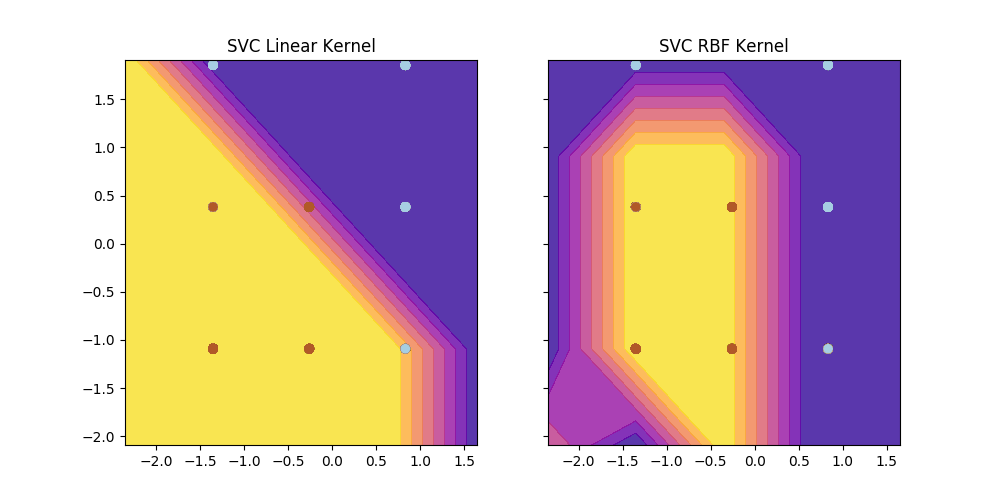

In [4]:
from IPython.display import Image
Image(filename='Figure_1.png')

#### regularization variation (C): 1, 10, 100, 1000

In [6]:
def regularization_variation(X, y, data_train, class_train, data_test, class_test):
    f, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 5))
    for a, C in zip(ax, (1, 10, 100, 1000)):
        svc = SVC(kernel='rbf', C=C, gamma=0.1).fit(X, y)
        svm_use('rbf', C, 0.1, data_train, class_train, data_test, class_test)
        plots_draw(X, y, svc, a)
    ax[0].set_title('C = 1')
    ax[1].set_title('C = 10')
    ax[2].set_title('C = 100')
    ax[3].set_title('C = 1000')
    plt.show()

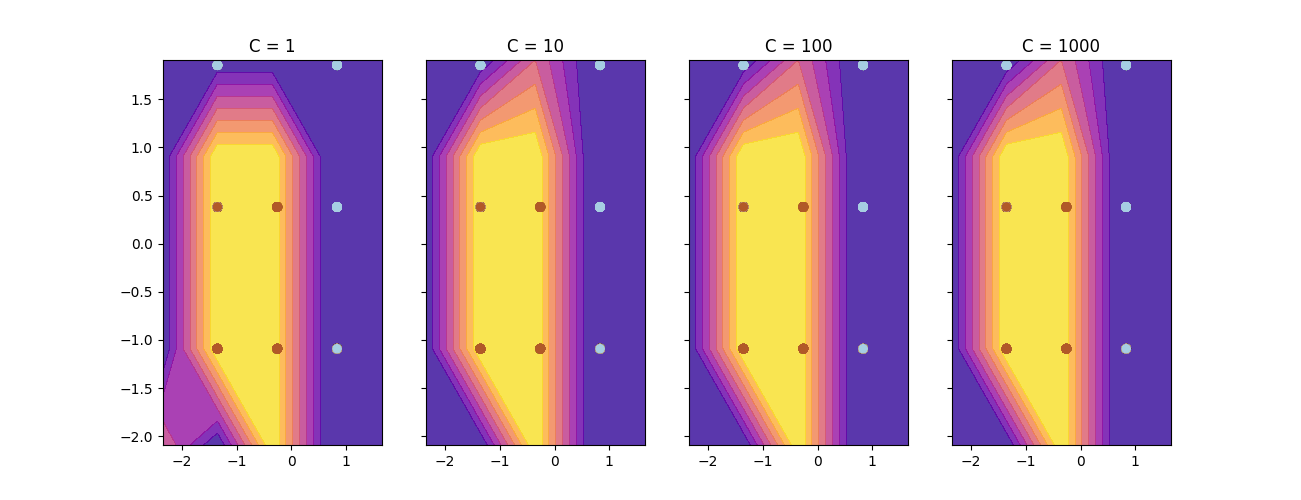

In [6]:
from IPython.display import Image
Image(filename='Figure_2.png')

#### core coefficient variation (gamma): 0.1, 10, 100, 1000

In [5]:
def core_coefficient_variation(X, y, data_train, class_train, data_test, class_test):
    f, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 5))
    for a, gamma in zip(ax, (0.1, 10, 100, 1000)):
        svc = SVC(kernel='rbf', C=1, gamma=gamma).fit(X, y)
        svm_use('rbf', 1, gamma, data_train, class_train, data_test, class_test)
        plots_draw(X, y, svc, a)
    ax[0].set_title('RBF gamma = 0.1')
    ax[1].set_title('RBF gamma = 10')
    ax[2].set_title('RBF gamma = 100')
    ax[3].set_title('RBF gamma = 1000')
    plt.show()

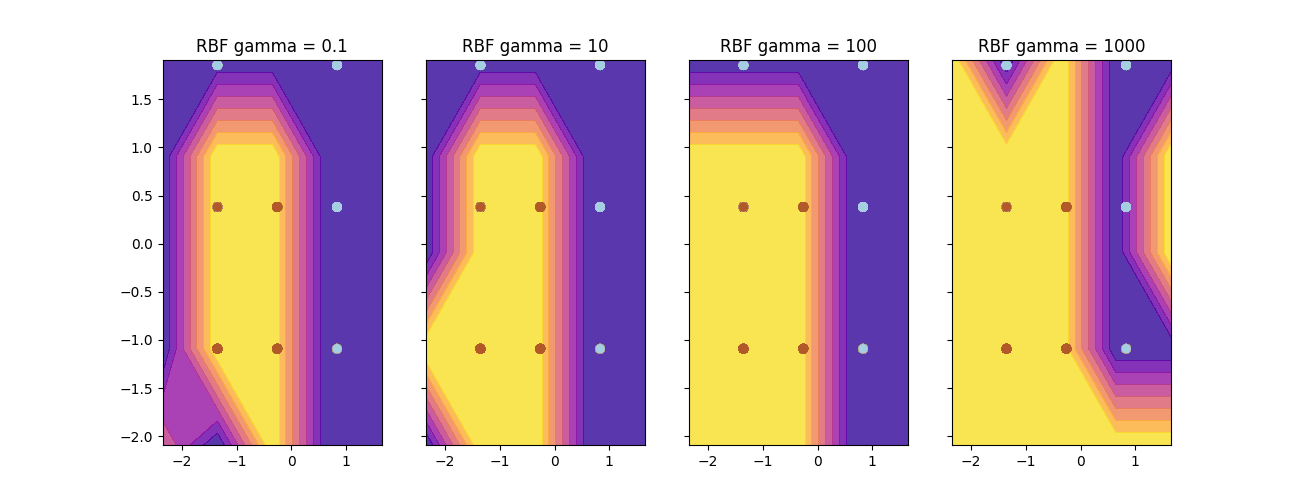

In [7]:
from IPython.display import Image
Image(filename='Figure_3.png')

| Algorithm        | Params         | Accurancy  |
| -----------------|----------------|----------|
| linear      | C = 1, gamma = 0.1 | 81.66% |
| rbf      | C = 1, gamma = 0.1      | 82.77% |
| rbf      | C = 10, gamma = 0.1      |  82.77%  |
| rbf      | C = 100, gamma = 0.1      |  82.77%  |
| rbf      | C = 1000, gamma = 0.1      |  82.77%  |
| rbf      | C = 1, gamma = 10      |  82.77%  |
| rbf      | C = 1, gamma = 100      |  82.77%  |
| rbf      | C = 1, gamma = 1000      |  82.77%  |

#### Вывод
Согласно результатам, полученным в ходе лабораторной работы, можно сделать вывод о том, что на исследуемом датасете точность резкльтата фактически не влияет метода. Это связано с особенностью датасета - все его параметры могут принимать только три значения: [-1; 1]. Варьирование коэффициентов для SVC метода с rbf ядром на точность (всегда равна 82.77%), как уже было сказано, не влияло, а метод с linear ядром показал немного меньший результат - 79.80%. Визуализация методов подтверждает факт невлияния варьирования параметров на общую точность